## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

### Data Load

In [2]:
# 데이터 로드
IVF_train = pd.read_csv('../data/IVF_train_dataset_18.csv')
IVF_test = pd.read_csv('../data/IVF_test_dataset_18.csv')

DI_train = pd.read_csv('../data/DI_train_dataset_18.csv')
DI_test = pd.read_csv('../data/DI_test_dataset_18.csv')

In [3]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X = IVF_train.drop(['임신_성공_여부', 'ID'], axis=1)
IVF_y = IVF_train['임신_성공_여부']

DI_X = DI_train.drop(['임신_성공_여부', 'ID'], axis=1)
DI_y = DI_train['임신_성공_여부']

### 인코딩 

In [4]:
IVF_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "배란_유도_유형",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "난자_채취_경과일",
    "난자_해동_경과일",
    "변환된_특정_시술_유형"
]

In [5]:
DI_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "정자_기증자_나이",
    "변환된_특정_시술_유형"
]

In [6]:
# 모든 범주형 변수를 문자열로 변환
IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
IVF_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
DI_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

IVF_X[IVF_categorical_columns] = IVF_encoder.fit_transform(IVF_X[IVF_categorical_columns])
DI_X[DI_categorical_columns] = DI_encoder.fit_transform(DI_X[DI_categorical_columns])
IVF_test[IVF_categorical_columns] = IVF_encoder.transform(IVF_test[IVF_categorical_columns])
DI_test[DI_categorical_columns] = DI_encoder.transform(DI_test[DI_categorical_columns])

## Modeling

In [7]:
# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)

### Optuna - IVF

In [9]:
import optuna
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 목적 함수 정의
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbose': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),  
        'num_leaves': trial.suggest_int('num_leaves', 10, 4096), 
        'max_depth': trial.suggest_int('max_depth', 3, 300), 
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1.0, log=True), 
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300), 
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 1e3, log=True),  
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1e3, log=True),  
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-6, 1e2, log=True),  
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'random_state': 42,
    }

    model = lgb.LGBMClassifier(**param)
    model.fit(IVF_X_train, IVF_y_train, eval_set=[(IVF_X_test, IVF_y_test)])
    
    y_pred_proba = model.predict_proba(IVF_X_test)[:, 1]
    auc = roc_auc_score(IVF_y_test, y_pred_proba)
    
    return auc

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=800)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# 최적의 하이퍼파라미터로 모델 학습
best_params = trial.params
IVF_model = lgb.LGBMClassifier(**best_params)
IVF_model.fit(IVF_X_train, IVF_y_train)

# 예측
y_pred = IVF_model.predict(IVF_X_test)
y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

# 평가
accuracy = accuracy_score(IVF_y_test, y_pred)
f1 = f1_score(IVF_y_test, y_pred)
auc = roc_auc_score(IVF_y_test, y_pred_proba)
cm = confusion_matrix(IVF_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

[I 2025-02-04 22:18:37,637] A new study created in memory with name: no-name-13bb570c-d1cc-4422-a96d-5dea7dea639e
[I 2025-02-04 22:19:42,602] Trial 0 finished with value: 0.7393239757670547 and parameters: {'n_estimators': 4353, 'num_leaves': 2947, 'max_depth': 66, 'learning_rate': 0.006569736514838241, 'min_child_samples': 17, 'subsample': 0.9015511702021448, 'colsample_bytree': 0.7029483212708357, 'reg_alpha': 1.705153922292892, 'reg_lambda': 0.00017524993728296062, 'min_split_gain': 1.5115758638629666, 'feature_fraction': 0.5427323209414376, 'bagging_fraction': 0.3226954100934618}. Best is trial 0 with value: 0.7393239757670547.
[I 2025-02-04 22:21:06,619] Trial 1 finished with value: 0.7392818021951989 and parameters: {'n_estimators': 4842, 'num_leaves': 2919, 'max_depth': 151, 'learning_rate': 0.0025031970790174163, 'min_child_samples': 107, 'subsample': 0.7025672085949612, 'colsample_bytree': 0.9230358563178949, 'reg_alpha': 0.00028300487742905845, 'reg_lambda': 1.862210386682235

KeyboardInterrupt: 

### IVF 데이터


--- Model Performance ---
Model Accuracy: 0.7462958149207174
Model F1 Score: 0.20341536916122552
Model AUC: 0.7401785794151994


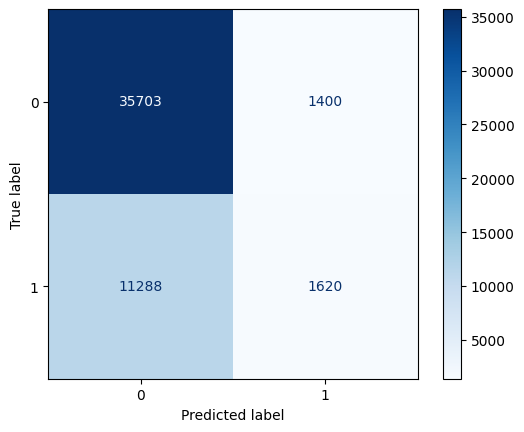

In [26]:
# 모델 초기화
IVF_model = lgb.LGBMClassifier(
    n_estimators=1258,
    num_leaves=923,
    max_depth=5,
    learning_rate=0.024413717866391526,
    min_child_samples=105,
    subsample=0.4890106069104924,
    colsample_bytree=0.4494069713807123,
    reg_alpha=3.0197481977859035,
    reg_lambda=0.4793565720612017,
    min_split_gain=0.29685405151668676,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습
IVF_model.fit(IVF_X_train, IVF_y_train)

# 예측
y_pred = IVF_model.predict(IVF_X_test)
y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

# 평가
accuracy = accuracy_score(IVF_y_test, y_pred)
f1 = f1_score(IVF_y_test, y_pred)
auc = roc_auc_score(IVF_y_test, y_pred_proba)
cm = confusion_matrix(IVF_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### DI 데이터


--- Model Performance ---
Model Accuracy: 0.8664546899841018
Model F1 Score: 0.0
Model AUC: 0.7085135430318916


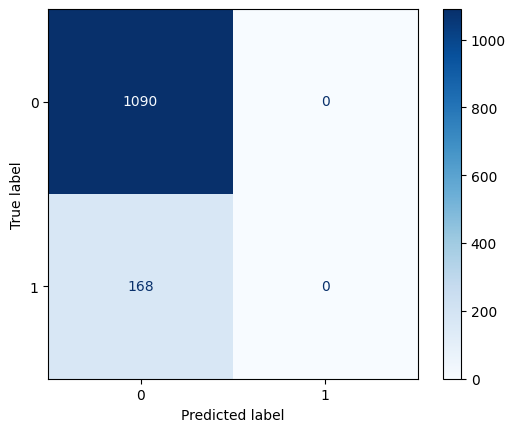

In [27]:
# 모델 초기화
DI_model = lgb.LGBMClassifier(
    n_estimators=2443,
    num_leaves=280,
    max_depth=149,
    learning_rate=0.061743249432816755,
    min_child_samples=176,
    subsample=0.9103802819067428,
    colsample_bytree=0.6636673663468106,
    reg_alpha=0.01173260476029451,
    reg_lambda=59.000778013447324,
    min_split_gain=1.1755604684312402,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습
DI_model.fit(DI_X_train, DI_y_train)

# 예측
y_pred = DI_model.predict(DI_X_test)
y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 평가
accuracy = accuracy_score(DI_y_test, y_pred)
f1 = f1_score(DI_y_test, y_pred)
auc = roc_auc_score(DI_y_test, y_pred_proba)
cm = confusion_matrix(DI_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DI_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


--- Model Performance ---
Model Accuracy: 0.749244182644483
Model F1 Score: 0.20129224652087474
Model AUC: 0.741842257077582


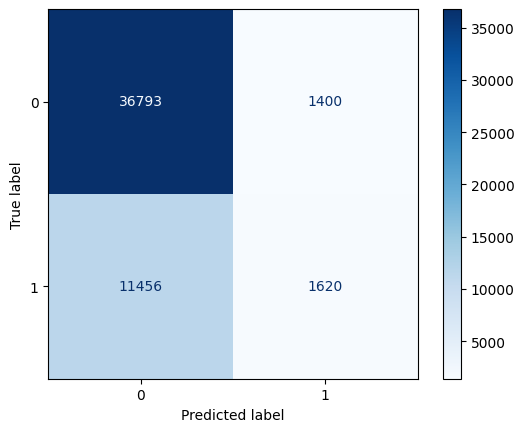

In [28]:
# 예측
IVF_y_pred = IVF_model.predict(IVF_X_test)
IVF_y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

DI_y_pred = DI_model.predict(DI_X_test)
DI_y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 예측 결과 병합
y_test = pd.concat([IVF_y_test, DI_y_test])
y_pred = pd.concat([pd.Series(IVF_y_pred, index=IVF_y_test.index), pd.Series(DI_y_pred, index=DI_y_test.index)])
y_pred_proba = pd.concat([pd.Series(IVF_y_pred_proba, index=IVF_y_test.index), pd.Series(DI_y_pred_proba, index=DI_y_test.index)])

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

데이콘 PUBLIC 몰루??

## 제출

In [18]:
# 모델 구축
IVF_model = lgb.LGBMClassifier(
    n_estimators=1258,
    num_leaves=923,
    max_depth=5,
    learning_rate=0.024413717866391526,
    min_child_samples=105,
    subsample=0.4890106069104924,
    colsample_bytree=0.4494069713807123,
    reg_alpha=3.0197481977859035,
    reg_lambda=0.4793565720612017,
    min_split_gain=0.29685405151668676,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

DI_model = lgb.LGBMClassifier(
    n_estimators=2443,
    num_leaves=280,
    max_depth=149,
    learning_rate=0.061743249432816755,
    min_child_samples=176,
    subsample=0.9103802819067428,
    colsample_bytree=0.6636673663468106,
    reg_alpha=0.01173260476029451,
    reg_lambda=59.000778013447324,
    min_split_gain=1.1755604684312402,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습 및 예측
IVF_model.fit(IVF_X, IVF_y)
IVF_pred_proba = IVF_model.predict_proba(IVF_test.drop('ID', axis=1))[:, 1]

DI_model.fit(DI_X, DI_y)
DI_pred_proba = DI_model.predict_proba(DI_test.drop('ID', axis=1))[:, 1]

In [19]:
# 예측 결과 병합
IVF_test['probability'] = IVF_pred_proba
DI_test['probability'] = DI_pred_proba

# 최종 제출 파일 생성
submission = pd.concat([IVF_test[['ID', 'probability']], DI_test[['ID', 'probability']]], axis=0)
submission = submission.sort_values(by='ID')  

# 제출 파일 저장
submission.to_csv('.submission/code18_submit.csv', index=False, encoding='utf-8')

.